# Se usó el código presente en la documentación de Pytorch referente a *__vision__* y se adaptó a nuestro dataset y al modelo EfficientNet_B0

**Existen dos escenarios principales de transferencia de aprendizaje:**
- **Fine Tune de ConvNet**:
    utiliza algunas de las capas superiores de un modelo para la extracción de características y entrenar conjuntamente tanto la parte recién agregada del modelo como estas capas superiores. Esto se llama ajuste fino porque ajusta ligeramente las representaciones más abstractas del modelo que se está reutilizando, para que sean más relevantes para el problema en cuestión.
    
- **ConvNet como extractor de características**:
    utiliza las representaciones aprendidas por una red anterior para extraer características interesantes de nuevas muestras. Estas características luego se ejecutan a través de un nuevo clasificador, que se entrena desde cero.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## En  este notebook se aplicara Fine Tune al modelo **EfficientNet_B0** con el objetivo de clasificar la frescura de frutas y vegetales

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

#cudnn.benchmark = True
#plt.ion()   # interactive mode

## Cargar DataSet

El dataset esta conformado con imagenes de Tomates y Platanos en los dos posibles estados de frescura (Fresco o Pasado). Se emplean los paquetes **torchvision** and **torch.utils.data**


In [3]:
#Dimensionar y normalizar datos para entrenamiento
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/my_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Mostrar imágenes del dataset


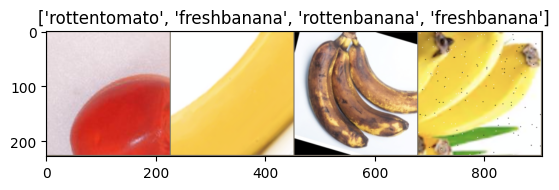

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Entrenar el modelo

Función para entrenar el modelo:
- Programación de la tasa de aprendizaje(learning rate)
- Guardar el mejor modelo




In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizar la predicción para un número de imágenes




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Fine-tuning

Cargar el modelo EfficientNet_b0 y modificar la última capa, la de clasificación





In [7]:
model_ft = models.efficientnet_b0(weights='IMAGENET1K_V1')
model_ft.classifier[1] = nn.Linear(1280, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 66.8MB/s]


### Entrenar y evaluar


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3555 Acc: 0.8656
val Loss: 0.0259 Acc: 0.9954

Epoch 1/24
----------
train Loss: 0.1607 Acc: 0.9401
val Loss: 0.0172 Acc: 0.9950

Epoch 2/24
----------
train Loss: 0.1023 Acc: 0.9614
val Loss: 0.0056 Acc: 0.9992

Epoch 3/24
----------
train Loss: 0.0873 Acc: 0.9709
val Loss: 0.0068 Acc: 0.9992

Epoch 4/24
----------
train Loss: 0.0764 Acc: 0.9722
val Loss: 0.0021 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.0653 Acc: 0.9763
val Loss: 0.0019 Acc: 0.9996

Epoch 6/24
----------
train Loss: 0.0616 Acc: 0.9785
val Loss: 0.0036 Acc: 0.9992

Epoch 7/24
----------
train Loss: 0.0473 Acc: 0.9834
val Loss: 0.0032 Acc: 0.9996

Epoch 8/24
----------
train Loss: 0.0396 Acc: 0.9853
val Loss: 0.0011 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0497 Acc: 0.9808
val Loss: 0.0018 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0363 Acc: 0.9870
val Loss: 0.0015 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0359 Acc: 0.9868
val Loss: 0.0012 Acc: 1.0000

Ep

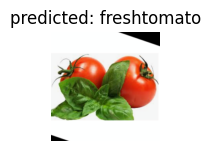

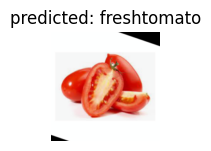

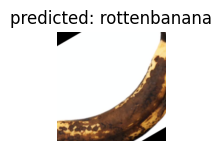

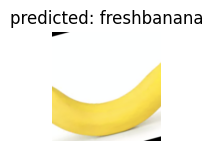

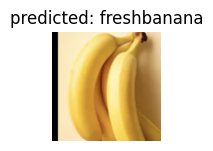

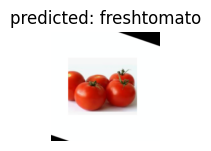

In [12]:
visualize_model(model_ft)